# V100实验结果

In [1]:
import numpy as np
import pandas as pd
import pylab as pl
from pylab import *
import plotly.offline as py
#import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.io as pio
import inspect, re
from plotly.subplots import make_subplots
py.init_notebook_mode(connected=True)
def varname(p):
	for line in inspect.getframeinfo(inspect.currentframe().f_back)[3]:
		m = re.search(r'\bvarname\s*\(\s*([A-Za-z_][A-Za-z0-9_]*)\s*\)', line)
	if m:
		return m.group(1)

In [25]:
segements=5
colors=[
#     '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]
def prepare_data(path,batchsize=256*16):
    batch_size = batchsize
    iterations = ceil(1282048/batch_size)
#     segements=5
    group_len = iterations/segements
    df = pd.read_csv(path)
    df['segament'] = (df['index']/(group_len)).astype('int')
    df.timestamp=pd.to_datetime(df.timestamp)
    df['time_cost']=df.timestamp-df.iloc[0].timestamp
    df.time_cost=df.time_cost/ pd.offsets.Minute(1)
    return df.groupby(['segament']).mean().copy()

# 查看train accuracy
def train_acc(datas, labels):
    go_data = []
    for data,label in zip(datas,labels):
        tmp = go.Scatter(
            x=data.index/segements if '_8' not in label else data.index/segements*2,
            y=data.training_accuracy,
            text='train acc',
            name=label
        )
        go_data.append(tmp)
    layout=go.Layout(title="train_acc", xaxis={'title':'Epochs'}, yaxis={'title':'%'},template="presentation")
    figure=go.Figure(data=go_data,layout=layout)
    py.iplot(figure)

# 查看train loss
def train_loss(datas, labels):
    go_data = []
    for data,label in zip(datas,labels):
        tmp = go.Scatter(
            x=data.index/segements if '_8' not in label else data.index/segements*2 ,
            y=data.training_loss,
            text='train loss',
            name=label
        )
        go_data.append(tmp)
    layout=go.Layout(margin=dict(t=10),template="presentation",xaxis={'title':'Epochs','mirror':True,'ticks':'inside','showline':True,'rangemode':"tozero"}, yaxis={'title':'Loss','mirror':True,'ticks':'inside','showline':True,'rangemode':"tozero"},legend=dict(x=0.7,y=0.9,bordercolor='#000000',
        borderwidth=2))
    figure=go.Figure(data=go_data,layout=layout)
    py.iplot(figure,)
    pio.write_image(figure, 'training_loss.png',scale=2)

# test accuracy
def test_acc(datas, labels):
    go_data = []
    for data,label in zip(datas,labels):
        data = data[data['test_loss']>0]
        tmp = go.Scatter(
            x=data.index/segements if '_8' not in label else data.index/segements*2 ,
            y=data.test_accuracy,
            text='test acc',
            name=label
        )
        go_data.append(tmp)
    layout=go.Layout(margin=dict(t=10),template="presentation",xaxis={'title':'Epochs','mirror':True,'ticks':'inside','showline':True,}, yaxis={'title':'Accuracy','mirror':True,'ticks':'inside','showline':True},legend=dict(x=0.7,y=0.1,bordercolor='#000000',
        borderwidth=2))
    figure=go.Figure(data=go_data,layout=layout)
    py.iplot(figure)
    pio.write_image(figure, 'test_acc.png',scale=2)
#     py.plot(figure,image='svg',filename='test_acc.html')
# 查看test loss
def test_loss(datas, labels):
    go_data = []
    for data,label in zip(datas,labels):
        data = data[data['test_loss']>0]
        tmp = go.Scatter(
            x=data.index/segements if '_8' not in label else data.index/segements*2 ,
            y=data.test_loss,
            name=label,
            text='test loss'
        )
        go_data.append(tmp)
    layout=go.Layout(margin=dict(t=10),template="presentation",xaxis={'title':'Epochs','mirror':True,'ticks':'inside','showline':True,}, yaxis={'title':'Loss','mirror':True,'ticks':'inside','showline':True},legend=dict(x=0.7,y=0.9,bordercolor='#000000',
        borderwidth=2))
    figure=go.Figure(data=go_data,layout=layout)
    py.iplot(figure,)
    pio.write_image(figure, 'test_loss.png',scale=2)

def subplot(datas,labels):
    grid = make_subplots(rows=1, cols=2)
    go_data = []
    color_idx=0
    for data,label in zip(datas,labels):
#         data = data[data['test_loss']>0]
        tmp = go.Scatter(
            x=data.index/segements if '_8' not in label else data.index/segements*2 ,
            y=data.training_loss,
            legendgroup=label,
            name=label,
            marker=dict(
                color=colors[color_idx],
            ),
            text='test acc'
        )
        grid.append_trace(tmp,row=1,col=1)
        go_data.append(tmp)
        color_idx+=1
    color_idx=0
    for data,label in zip(datas,labels):
        data = data[data['test_loss']>0]
        tmp = go.Scatter(
            x=data.index/segements if '_8' not in label else data.index/segements*2 ,
            y=data.test_accuracy,
            legendgroup=label,
            name=label,
            showlegend = False,
            marker=dict(
                color=colors[color_idx],
            ),
            text='test loss',
        )
        grid.append_trace(tmp,row=1,col=2)
        go_data.append(tmp)
        color_idx+=1
    grid.update_layout(height=600,width=1000,template="presentation",
                       xaxis={'title':'Epochs','mirror':True,'ticks':'inside','showline':True,},
                       yaxis={'title':'Train Loss','mirror':True,'ticks':'inside','showline':True},
                       xaxis2={'title':'Epochs','mirror':True,'ticks':'inside','showline':True,},
                       yaxis2={'title':'Test Accuracy','mirror':True,'ticks':'inside','showline':True},
                       legend=dict(x=0.25,y=0.9,bordercolor='#000000',
        borderwidth=2))
    py.iplot(grid)
    pio.write_image(grid, 'sub_plot.pdf',scale=2)
#     grid.show()


In [28]:
# resnet-18 16workers

DGS = prepare_data('~/share/DGS/log/result_imagenet/node11_gradient_sgd_resnet18_m0.45_e120_b256_16worker.csv')[:450]
asgd = prepare_data('~/share/DGS/log/result_imagenet/node9_asgd_resnet18_m0.45_e120_b256_16worker.csv')[:450]
DGC = prepare_data('~/share/DGS/log/result_imagenet/node8_dgc_resnet18_m0.45_e120_b256_16worker.csv')[:450]
aji = prepare_data('~/share/DGS/log/result_imagenet/node2_aji_resnet18_m0.45_e90_b256_16worker.csv')[:450]
datas_str = '[DGS,asgd,DGC,aji]'
datas=eval(datas_str)
labels=[i.replace('[','').replace(']','') for i in datas_str.split(',')]
labels=['DGS','ASGD','DGC-async','GD-async']
# train_acc(datas,labels)
# train_loss(datas,labels)
# test_acc(datas,labels)
# test_loss(datas,labels)
subplot(datas,labels)
# for i in datas:
#     print(DGS.test_accuracy.max())

In [29]:
# resnet-18 4workers

DGS = prepare_data('~/share/DGS/log/result_imagenet/node0_gradient_sgd_resnet18_m0.7_e90_b256_4worker.csv',batchsize=256*4)
asgd = prepare_data('~/share/DGS/log/result_imagenet/node2_asgd_resnet18_m0.7_e90_b256_4worker.csv',batchsize=256*4)
DGC = prepare_data('~/share/DGS/log/result_imagenet/node2_dgc_resnet18_m0.7_e90_b256_4worker.csv',batchsize=256*4)
aji = prepare_data('~/share/DGS/log/result_imagenet/node1_aji_resnet18_m0.7_e90_b256_4worker.csv',batchsize=256*4)
datas_str = '[DGS,asgd,DGC,aji]'
datas=eval(datas_str)
labels=[i.replace('[','').replace(']','') for i in datas_str.split(',')]
labels=['DGS','ASGD','DGC-async','GD-async']
# train_acc(datas,labels)
# train_loss(datas,labels)
# test_acc(datas,labels)
# test_loss(datas,labels)
subplot(datas,labels)
# for i in datas:
#     print(i.test_accuracy.max())

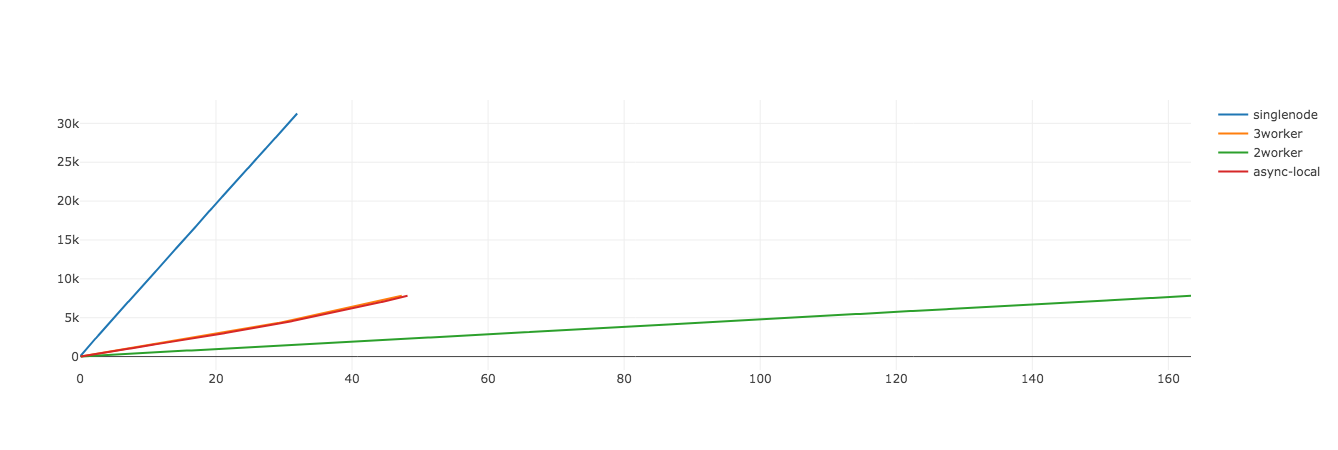

In [273]:
# 查看随着时间的变化，index的变化，说明了节点运行速度的比较
singlenode = go.Scatter(
    x=single_node_train_data.time_cost,
    y=single_node_train_data['index'],
    name='singlenode'
)
dsnode_1 = go.Scatter(
    x=ds_node_1_train_data.time_cost,
    y=ds_node_1_train_data['index'],
    name='3worker',
)
dsnode_2 = go.Scatter(
    x=ds_node_2_train_data.time_cost,
    y=ds_node_2_train_data['index'],
    name='2worker',
)
asnode_1 = go.Scatter(
    x=as_node_1_train_data.time_cost,
    y=as_node_1_train_data['index'],
    name='async-local',
)
data = [singlenode,dsnode_1,dsnode_2,asnode_1]
py.iplot(data)

In [55]:
# speed up

def speedup_subplot(x,datas1,labels1,datas2,labels2):
    grid = make_subplots(rows=1, cols=2)
    go_data = []
    color_idx=0
    for data,label in zip(datas1,labels1):
        tmp = go.Scatter(
            x=x,
            y=data,
            legendgroup=label,
            name=label,
            marker=dict(
                color=colors[color_idx],
            ),
            text='Speedup with 10Gbps Ethernet'
        )
        grid.append_trace(tmp,row=1,col=1)
        go_data.append(tmp)
        color_idx+=1
    color_idx=0
    for data,label in zip(datas2,labels2):
        tmp = go.Scatter(
            x=x ,
            y=data,
            legendgroup=label,
            name=label,
            showlegend = False,
            marker=dict(
                color=colors[color_idx],
            ),
            text='Speedup with 1Gbps Ethernet',
        )
        grid.append_trace(tmp,row=1,col=2)
        go_data.append(tmp)
        color_idx+=1
    grid.update_layout(height=600,width=1000,template="presentation",
                       xaxis={'title':'Epochs','mirror':True,'ticks':'inside','showline':True,'tick0':0},
                       yaxis={'title':'Train Loss','mirror':True,'ticks':'inside','showline':True,'tick0':0},
                       xaxis2={'title':'Epochs','mirror':True,'ticks':'inside','showline':True,},
                       yaxis2={'title':'Test Accuracy','mirror':True,'ticks':'inside','showline':True,'tick0':0},
                       legend=dict(x=0.25,y=0.9,bordercolor='#000000',
        borderwidth=2))
    py.iplot(grid)
    pio.write_image(grid, 'speedup_sub_plot.pdf',scale=2)
    
def cal_speedup(x,comm,cal):
    print(np.array(0.330/(comm+cal)*x))
    return np.array(0.330/(comm+cal)*x)
#x: 1 2 4 8 16

x = np.array([1,2,4,8,16])
DGS_10gbps_cal = np.array([0.330,0.330,0.331,0.344,0.375])
DGS_10gbps_comm = np.array([0.008,0.008,0.008,0.008,0.012])
DGS_1gpbs_comm= np.array([0.08,0,0,0,0])
ASGD_10gbps_comm = np.array([0.169,0.197,0.254,0.481,1.007]) # overhead in here
ASGD_1gbps_comm =np.array([0.903,1.32,1.4,3.25,5])
datas1 = [cal_speedup(x,DGS_10gbps_comm,DGS_10gbps_cal),cal_speedup(x,DGS_10gbps_comm,ASGD_10gbps_comm)]
datas2 = [cal_speedup(x,DGS_10gbps_comm,DGS_1gpbs_comm),cal_speedup(x,DGS_10gbps_comm,ASGD_1gbps_comm)]
speedup_subplot(x,datas1,['DGS','ASGD'],datas2,['DGS','ASGD'])


[ 0.97633136  1.95266272  3.89380531  7.5        13.64341085]
[1.86440678 3.2195122  5.03816794 5.39877301 5.18155054]
[  3.75  82.5  165.   330.   440.  ]
[0.3622393  0.49698795 0.9375     0.81031308 1.05347167]


In [49]:
DGS_10gbps_cal/x

array([0.33     , 0.165    , 0.08275  , 0.043    , 0.0234375])